In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow
import pandas as pd

In [3]:
EPOCHS = 40
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/Apple_Leaf_Disease/plant_images'
width=256
height=256
depth=3

In [23]:
train=pd.read_csv(r"/content/drive/MyDrive/Apple_Leaf_Disease/plant_img/train.csv")
test=pd.read_csv(r"/content/drive/MyDrive/Apple_Leaf_Disease/plant_img/test.csv")

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing apple_multiple ...
[INFO] Processing apple_healthy ...
[INFO] Processing apple_scab ...
[INFO] Processing apple_rust ...
[INFO] Image loading completed


In [6]:
image_size = len(image_list)

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['apple_healthy' 'apple_multiple' 'apple_rust' 'apple_scab']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [14]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

<ipython-input-15-f5a41846f0f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
17/17 [==============================] - 20s 506ms/step - loss: 1.0925 - accuracy: 0.3269 - val_loss: 1.2104 - val_accuracy: 0.2806
Epoch 2/40
17/17 [==============================] - 9s 517ms/step - loss: 0.8561 - accuracy: 0.3423 - val_loss: 0.7782 - val_accuracy: 0.2878
Epoch 3/40
17/17 [==============================] - 8s 480ms/step - loss: 0.7839 - accuracy: 0.3577 - val_loss: 1.2885 - val_accuracy: 0.2806
Epoch 4/40
17/17 [==============================] - 8s 447ms/step - loss: 0.6784 - accuracy: 0.3865 - val_loss: 0.8226 - val_accuracy: 0.2518
Epoch 5/40
17/17 [==============================] - 9s 516ms/step - loss: 0.7029 - accuracy: 0.3654 - val_loss: 0.6975 - val_accuracy: 0.2518
Epoch 6/40
17/17 [==============================] - 7s 434ms/step - loss: 0.6302 - accuracy: 0.4212 - val_loss: 0.6085 - val_accuracy: 0.3022
Epoch 7/40
17/17 [==============================] - 9s 485ms/step - loss: 0.6149 - accuracy: 0.4481 - val_loss: 0.7570 - val_accuracy: 0.2518
Epoch

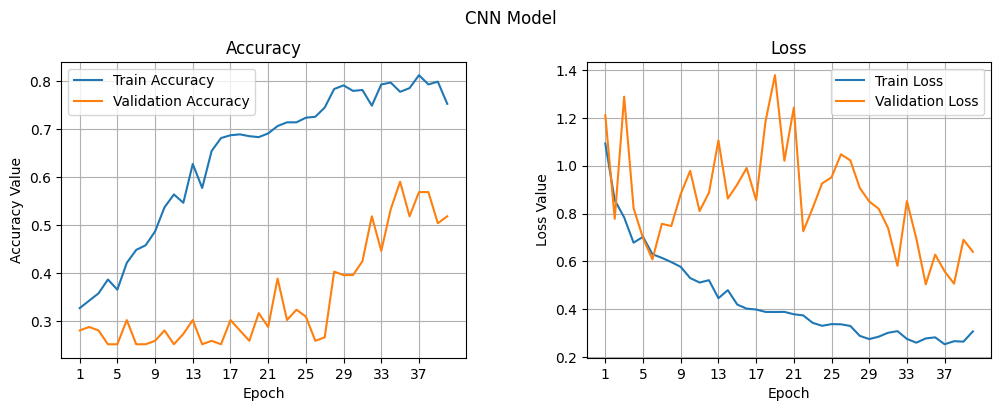

In [16]:
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [19]:
from keras import metrics
import keras
model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=[metrics.mae,
                       metrics.categorical_accuracy])

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<Axes: >

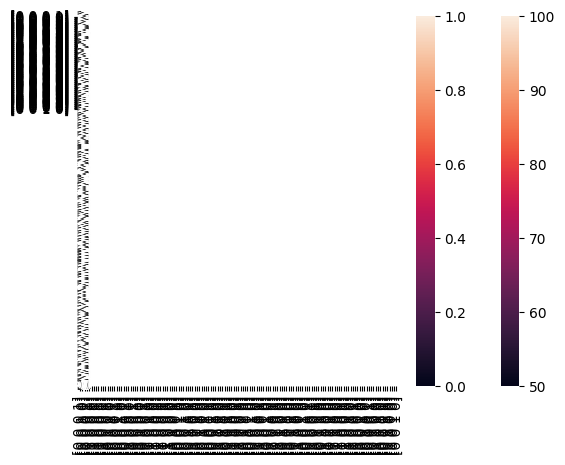

In [24]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
train['image_id']= le.fit_transform(train['image_id'])
sns.heatmap(train, vmin=50, vmax=100)
sns.heatmap(y_train, annot=True,xticklabels=y_test, yticklabels=y_test)


In [25]:
model.compile(metrics=[1,224,224,3])

In [26]:
def recall(test_image, result):
    y_true = K.ones_like(test_image)
    true_positives = K.sum(K.round(K.clip(test_image * result, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(test_image, result):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(test_image * result, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(test_image, result):
    precision = precision_m(test_image, result)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(metrics=['accuracy', f1_score, precision, recall])
x_train.shape

(552, 256, 256, 3)

In [27]:
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [33]:
le =LabelEncoder()
train['image_id']= le.fit_transform(train['image_id'])
train['image_id'].unique()
le =LabelEncoder()
test['image_id']= le.fit_transform(test['image_id'])
test['image_id'].unique()
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=42)
logmodel = tree.DecisionTreeClassifier()
logmodel.fit(X_train, y_train)

DecisionTreeClassifier()

In [34]:
predictions = logmodel.predict(X_test)
classification_report(y_test,predictions)
print(confusion_matrix(y_test, predictions))
classifier_tree = tree.DecisionTreeClassifier()
y_predict = classifier_tree.fit(X_train, y_train).predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


In [35]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       1.0
          11       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       0.0
          32       0.00      0.00      0.00       0.0
          33       0.00      0.00      0.00       1.0
          38       0.00      0.00      0.00       0.0
          39       0.00      0.00      0.00       0.0
          40       0.00      0.00      0.00       1.0
          41       0.00      0.00      0.00       1.0
          43       0.00      0.00      0.00       1.0
          45       0.00      0.00      0.00       0.0
          48       0.00      0.00      0.00       1.0
          49       0.00      0.00      0.00       0.0
          51       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [36]:
import pandas as pd
X=pd.read_csv(r"/content/drive/MyDrive/Apple_Leaf_Disease/plant_img/train.csv")
y=pd.read_csv(r"/content/drive/MyDrive/Apple_Leaf_Disease/plant_img/test.csv")

In [37]:
le =LabelEncoder()
X['image_id']= le.fit_transform(X['image_id'])
X['image_id'].unique()
y['image_id']= le.fit_transform(y['image_id'])
y['image_id'].unique()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


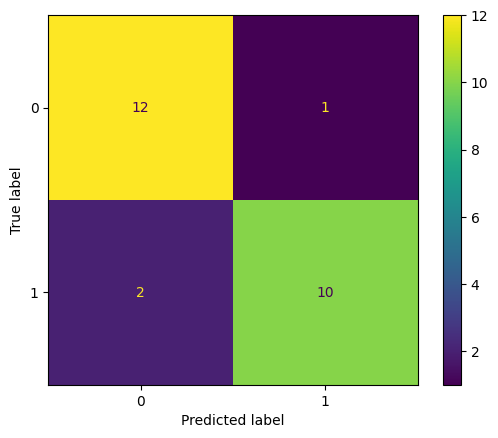

In [38]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [39]:
from sklearn import metrics
Accuracy = metrics.accuracy_score(y_test, predictions)
Precision = metrics.precision_score(y_test, predictions)
Sensitivity_recall = metrics.recall_score(y_test, predictions)
Specificity = metrics.recall_score(y_test, predictions, pos_label=0)
F1_score = metrics.f1_score(y_test, predictions)

In [40]:
print({"Accuracy":Accuracy,
       "Precision":Precision,
       "Sensitivity_recall":Sensitivity_recall,
       "Specificity":Specificity,
       "F1_score":F1_score})

{'Accuracy': 0.88, 'Precision': 0.9090909090909091, 'Sensitivity_recall': 0.8333333333333334, 'Specificity': 0.9230769230769231, 'F1_score': 0.8695652173913043}


Found 1821 files belonging to 4 classes.
(32, 256, 256, 3)
[3 3 3 2 3 2 0 0 2 2 2 2 1 3 2 0 3 2 0 3 3 0 0 0 2 2 2 3 0 1 0 3]
first image to predict
actual label: apple_rust
1/1 [==============================] - 0s 42ms/step
predicted label: apple_rust


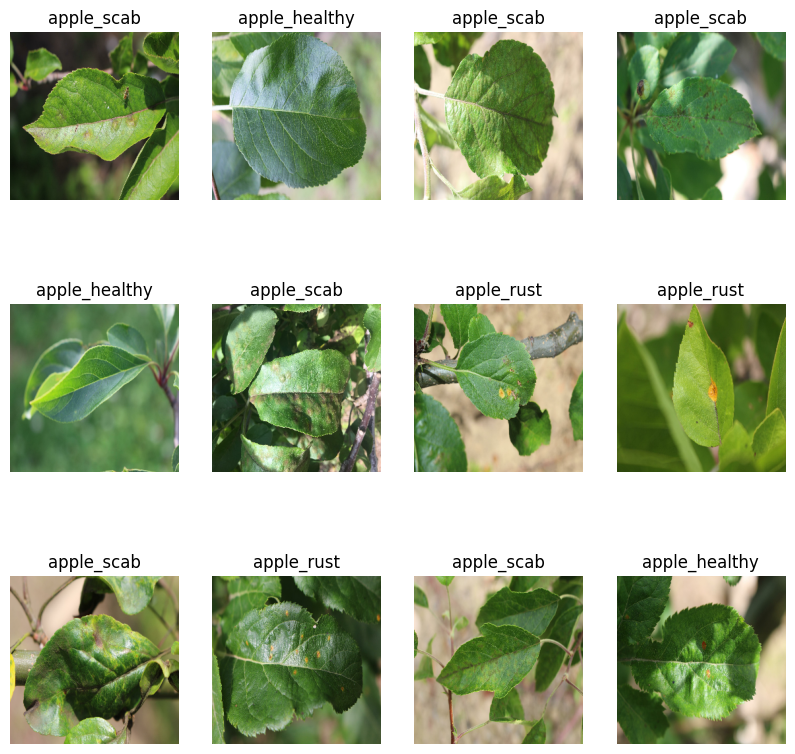

In [42]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Apple_Leaf_Disease/plant_images/apple",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        plt.savefig('prediction',dpi=400)

import numpy as np
for images_batch, labels_batch in dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[1])])

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
        plt.savefig('pre_con',dpi=400)

Output hidden; open in https://colab.research.google.com to view.